<a href="https://colab.research.google.com/github/Saheli-deb/Breast-Cancer-Analyser/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

import os, shutil, pathlib, glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import random
SEED = 4747
random.seed(SEED)

In [ ]:
from google.colab import files


uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
#Create "~/.kaggle" directory
!mkdir ~/.kaggle

#Move "kaggle.json" file to this directory
!mv kaggle.json ~/.kaggle/

#Change the file access rights to the current user only
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Download the dataset with API command
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:28<00:00, 201MB/s]
100% 3.10G/3.10G [00:28<00:00, 115MB/s]


In [ ]:
#List all the files
!ls

breast-histopathology-images.zip  sample_data


In [ ]:
#Create a directory "dataset" to unzip the file there
!mkdir dataset

In [ ]:
#List all the files
!ls

breast-histopathology-images.zip  dataset  sample_data


In [ ]:
#Unzip the dataset quitely using "qq" flag
# to the "dataset" directory using "d" flag
!unzip -qq "/content/breast-histopathology-images.zip" -d "/content/dataset"

EDA

In [ ]:
import os # import the os module to get access to os functions such as listdir
#Total directories (that is, total number of patients)
dirs = os.listdir("/content/dataset/")
print("Total number of directories are =",len(dirs))

Total number of directories are = 280


The last directory "IDC_regular_ps50_idx5" is duplicate and has different directory structure. So, we'll remove that from our list.

In [ ]:
dirs.remove("IDC_regular_ps50_idx5")
print(print("Total number of directories are =",len(dirs)))

Total number of directories are = 279
None


In [ ]:
"""
This functions accepts the class value of either:
      - "0": for normal tissues
      - "1": for cancer tissues
and plots 49 random Histopathological images of that class.
"""
import matplotlib.pyplot as plt # import the pyplot module from matplotlib
import random # Import the random module
import glob # Import the glob module
import pathlib # Import the pathlib module here
#Import load_img from tensorflow.keras.utils instead of tensorflow.keras.preprocessing.image
from tensorflow.keras.utils import load_img

def plot_random_patches(clas):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for ax in axes.flatten():
        #Get a random patient id
        patient_id = random.choice(dirs)

        path = f"/content/dataset/{patient_id}/{clas}/*.png"
        #Read all the files' path present in "path" directory
        paths = glob.glob(path)
        #Select a random file path
        p = random.choice(paths)
        #Get the path with semantics appropriate for underlying OS
        p = pathlib.Path(p)
        #Load the image
        img = load_img(p)
        #Plot theimage
        ax.imshow(img)
        #Set image properties
        ax.set_title(label=patient_id, fontdict={"fontsize":8})
        ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

    #Use different image title for cancer and normal tissues
    if clas == 1:
        fig.suptitle('IDC+ patches\n(Cancer tissues)', fontsize=16)
    else:
        fig.suptitle('IDC- patches\n(Noraml tissues)', fontsize=16)

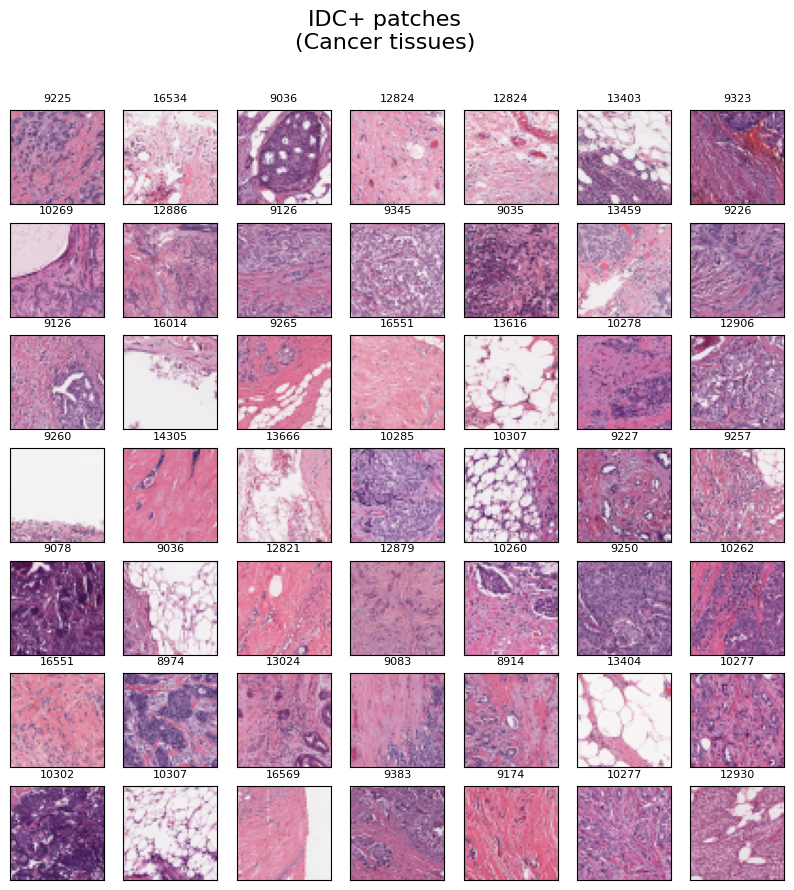

In [ ]:
#Plot random images of IDC+ / cancer tissues
plot_random_patches(clas=1)

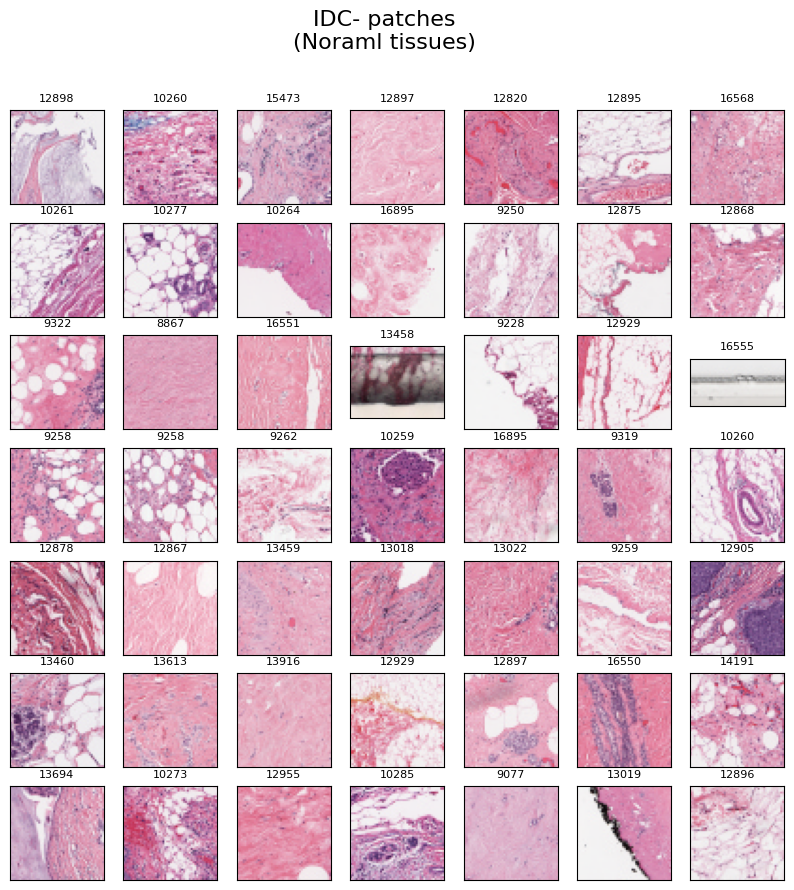

In [ ]:
#Plot random images of IDC- / noraml tissues
plot_random_patches(clas=0)

In [ ]:
"""
This function accepts the "patient id" as argument and returns a DataFrame
that has following 4 columns:
 1) "x":      x-coordinate of where this image patch was cropped from
 2) "y":      y-coordinate of where this image patch was cropped from
 3) "class":  The class to which the image patch belongs
 4) "path":   Path of each image patch in the directory
"""
import pandas as pd # Import the pandas library here to define 'pd'

def convert_patient_metadata_to_df(patient_id):
    #Create a DataFrame "xy" to store the patient metadata
    xy = pd.DataFrame(data=None, columns = ['x','y','class','path'])
    #Create an "index" variable to querry DataFrame "xy"
    index = 0
    for clas in [0,1]:
        #Get the list of paths to the all patch images of a certain patient
        paths = glob.glob(f"/content/dataset/{patient_id}/{clas}/*.png")
        for path in paths:
            #Since the image name contains the required information as explained
            #in the dataset description, we'll split the path string
            # and store the required values
            p = path.split("_")
            xy.loc[index,"x"] = int(p[2][1:])
            xy.loc[index,'y'] = int(p[3][1:])
            xy.loc[index,"class"] = int(p[4][5])
            xy.loc[index,"path"] = path
            #Increment the index
            index+=1
    #Return the DataFrame "xy" containing the required information
    #about a certain patient
    return xy

In [ ]:
import numpy as np # Import the numpy library and alias it as 'np'

def get_full_Histopathological_image_of_breast(patient_id):

    #Use the "convert_patient_metadata_to_df" function to
    #get the x and y coordinates of image patches, class value and
    #image patch's path
    xy = convert_patient_metadata_to_df(patient_id)
    #Get the maximum value of x and y coordinate and store it in a list
    xy_max = [int(xy.x.max())-1, int(xy.y.max())-1]
    #print(xy_max) # Print xy_max for debugging


    #Make a white grid for complete histopathological breast image based
    #on the maximum values of x and y
    histopathological_img = np.ones(shape=(xy_max[1]+1,xy_max[0]+1,3), dtype=np.uint8)*255

    #Create a mask that highlights the cancer tissues in green color
    mask = np.zeros(shape=(xy_max[1]+1,xy_max[0]+1,3), dtype=np.uint8)

    #Iterate over the DataFrame "xy" which containes x,y coordinates, class
    #and path of every image patch
    for i in range(len(xy)):
        #Load the image using load_img function from keras.preprocessing
        #Since we are loading the image with the original size we'll specify
        #the target_size argument
        img = load_img(xy.loc[i,"path"], target_size=(50,50))
        #Convert the image to numpy array using img_to_array function from
        #keras.preprocessing
        img = np.array(img)

        #Get the x, y coordinates and the class value
        x_coord = xy.loc[i,"x"]
        y_coord = xy.loc[i,"y"]
        clas = xy.loc[i,"class"]

        # Debugging: Print coordinates and image shape
        #print(f"x_coord: {x_coord}, y_coord: {y_coord}, img.shape: {img.shape}")
        #print(f"Slice shape: {(y_coord+50, x_coord+50)}")

        #Since, by iterating, we are combining all the small image patches
        #to create the complete histopathological image of the breast tissue
        #we'll paste the small image patch to corresponding x,y coordinates
        #on the big white grid "histopathological_img"
        # Ensure x_coord + 50 and y_coord + 50 are within bounds
        histopathological_img[y_coord:min(y_coord+50, histopathological_img.shape[0]), x_coord:min(x_coord+50, histopathological_img.shape[1])] = img[:min(50, histopathological_img.shape[0] - y_coord), :min(50, histopathological_img.shape[1] - x_coord)]


        #If the class value is 1 (that is, it represents IDC+)
        #then we'll make the corresponding pixels green in the "mask"
        if clas == 1:
            mask[y_coord:min(y_coord+50, mask.shape[0]), x_coord:min(x_coord+50, mask.shape[1])] = (0,255,0)

    # Return the constructed images
    return histopathological_img, mask # Added return statement

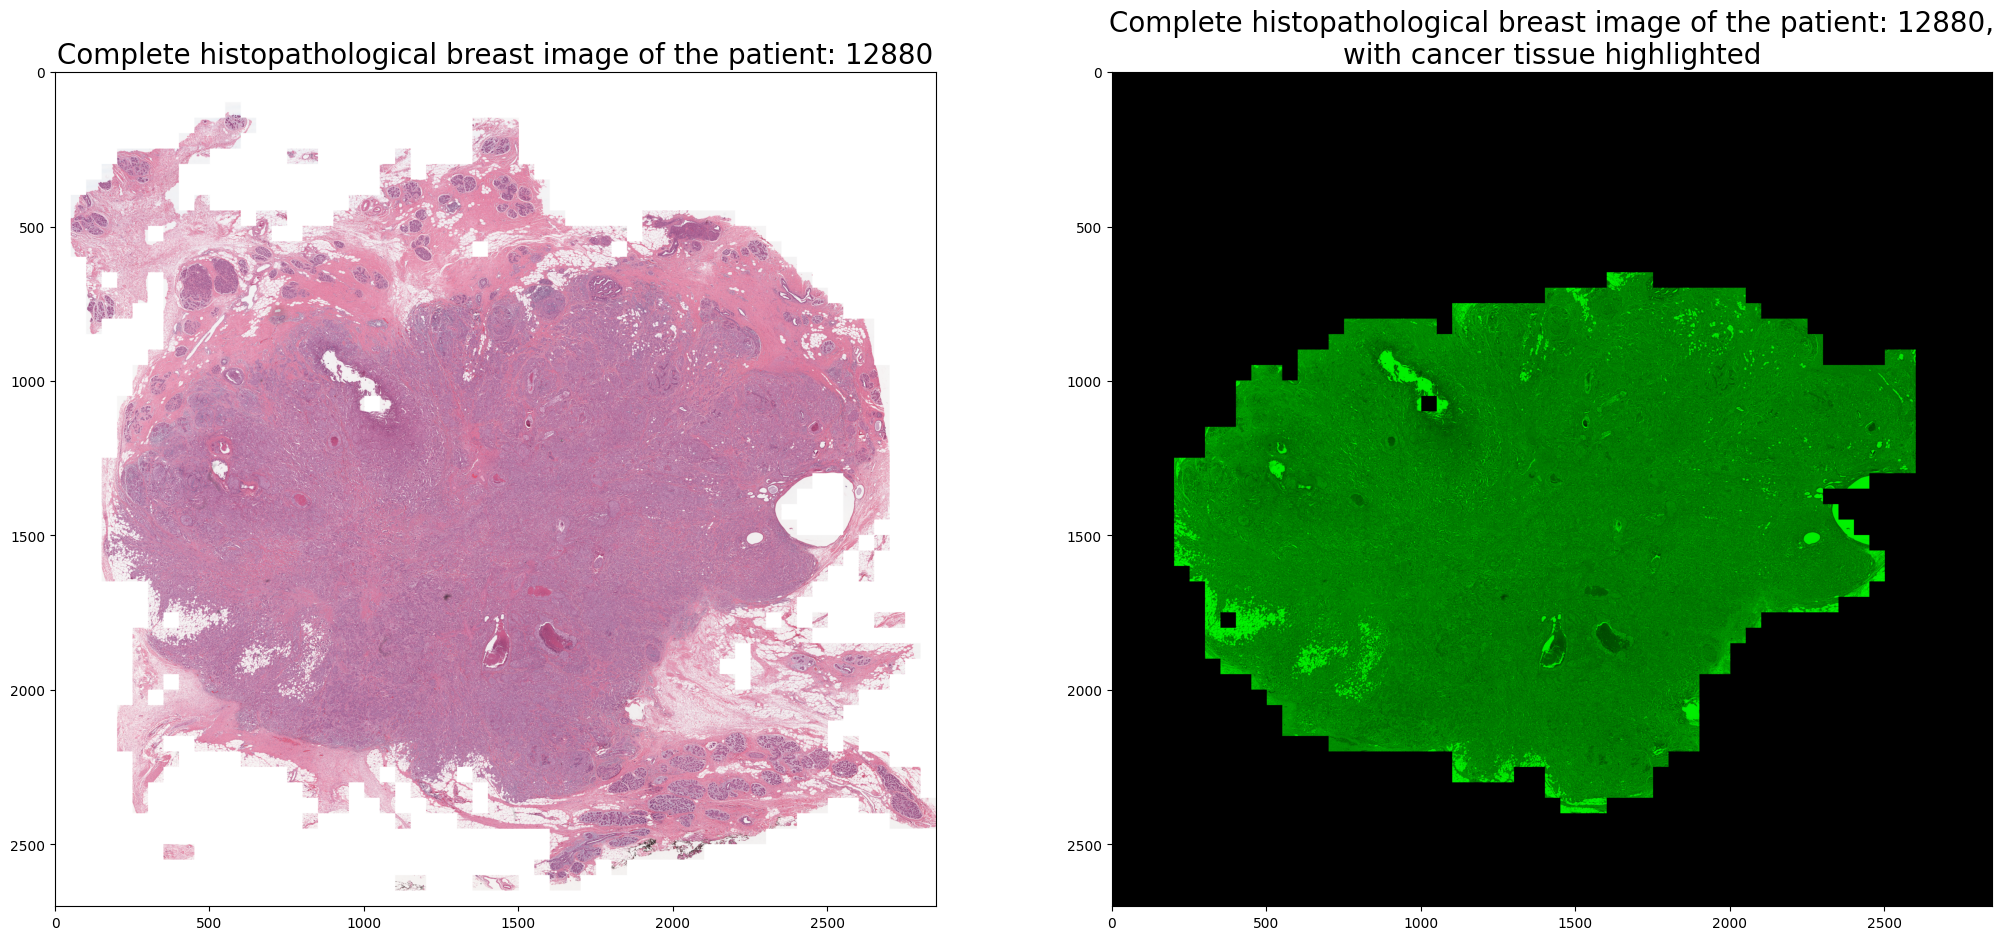

In [ ]:
#Plot the full histopathological image of breast tissue of patient "12880"
import cv2 # Import the cv2 module here
patient_id = "12880"
#Get Histopathological Image of breast of patient "12880"
histopathological_img, mask = get_full_Histopathological_image_of_breast(patient_id)
#Perform bitwise AND operation using OpenCV to combine the
# "mask", that highlights the cancer tissues in green, with "histopathological_img"
masked = cv2.bitwise_and(histopathological_img,mask)

#Plot the images
fig, ax = plt.subplots(1,2,figsize=(25,12))
ax[0].imshow(histopathological_img)
ax[0].set_title(f"Complete histopathological breast image of the patient: {patient_id}")
ax[0].title.set_size(20)

ax[1].imshow(masked)
ax[1].set_title(f"Complete histopathological breast image of the patient: {patient_id},\nwith cancer tissue highlighted");
ax[1].title.set_size(20)

## Preprocessing

We will create dataset for:

- Training
- Validation
- Testing

We will create a new directory that will store random images. The directory structure will be like the following.


```
├── new_dataset
    ├── training
        ├── 0
            ├── 10253_idx5_x1001_y1001_class0.png
            ├── 10253_idx5_x1001_y1051_class0.png
            .
            .
            └── 10253_idx5_x1001_y1251_class0.png
        └── 1
            ├── 10253_idx5_x501_y351_class1.png
            ├── 10253_idx5_x501_y401_class1.png
            .
            .
            └── 10253_idx5_x551_y401_class1.png

    └── testing
        ├── 0
            ├── 10253_idx5_x1001_y1001_class0.png
            ├── 10253_idx5_x1001_y1051_class0.png
            .
            .
            └── 10253_idx5_x1001_y1251_class0.png
        └── 1
            ├── 10253_idx5_x501_y351_class1.png
            ├── 10253_idx5_x501_y401_class1.png
            .
            .
            └── 10253_idx5_x551_y401_class1.png

```

In [ ]:
#Create "new dataset" directory
!mkdir new_dataset

In [ ]:
#List all the file
!ls

breast-histopathology-images.zip  dataset  new_dataset	sample_data


In [ ]:
"""
This function returns two lists containing the paths
of all the images of class 0 and class 1.
"""

def get_image_path_list():
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0),random.shuffle(c_0)
        random.shuffle(c_1),random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0),random.shuffle(class_0)
        random.shuffle(class_1),random.shuffle(class_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1

In [ ]:
#Import necessary libraries
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

import os, shutil, pathlib, glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import random
SEED = 4747
random.seed(SEED)
# %% [markdown]
#
# %%
from google.colab import files


uploaded = files.upload()

# %%
#Create "~/.kaggle" directory
!mkdir ~/.kaggle

#Move "kaggle.json" file to this directory
!mv kaggle.json ~/.kaggle/

#Change the file access rights to the current user only
!chmod 600 ~/.kaggle/kaggle.json
# %%
#Download the dataset with API command
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
# %%
#List all the files
!ls
# %%
#Create a directory "dataset" to unzip the file there
!mkdir dataset
# %%
#List all the files
!ls
# %%
#Unzip the dataset quitely using "qq" flag
# to the "dataset" directory using "d" flag
!unzip -qq "/content/breast-histopathology-images.zip" -d "/content/dataset"
# %% [markdown]
# EDA
# %%
import os # import the os module to get access to os functions such as listdir
#Total directories (that is, total number of patients)
dirs = os.listdir("/content/dataset/")
print("Total number of directories are =",len(dirs))
# %% [markdown]
# The last directory "IDC_regular_ps50_idx5" is duplicate and has different directory structure. So, we'll remove that from our list.
# %%
dirs.remove("IDC_regular_ps50_idx5")
print(print("Total number of directories are =",len(dirs)))
# %%
"""
This functions accepts the class value of either:
      - "0": for normal tissues
      - "1": for cancer tissues
and plots 49 random Histopathological images of that class.
"""
import matplotlib.pyplot as plt # import the pyplot module from matplotlib
import random # Import the random module
import glob # Import the glob module
import pathlib # Import the pathlib module here
#Import load_img from tensorflow.keras.utils instead of tensorflow.keras.preprocessing.image
from tensorflow.keras.utils import load_img

def plot_random_patches(clas):
    fig, axes = plt.subplots(7,7,figsize=(10,10))
    for ax in axes.flatten():
        #Get a random patient id
        patient_id = random.choice(dirs)

        path = f"/content/dataset/{patient_id}/{clas}/*.png"
        #Read all the files' path present in "path" directory
        paths = glob.glob(path)
        #Select a random file path
        p = random.choice(paths)
        #Get the path with semantics appropriate for underlying OS
        p = pathlib.Path(p)
        #Load the image
        img = load_img(p)
        #Plot theimage
        ax.imshow(img)


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
100% 3.09G/3.10G [00:40<00:00, 185MB/s]
100% 3.10G/3.10G [00:40<00:00, 81.8MB/s]
breast-histopathology-images.zip  sample_data
breast-histopathology-images.zip  dataset  sample_data
Total number of directories are = 280
Total number of directories are = 279
None


In [ ]:
#Create the dataset using the function create_dataset()
# with 80% data for training and 20% for testing
create_dataset(train_split=0.80)

In [ ]:
"""
If you run the create_dataset() function more than once, the os.makedirs()
will generate "FileExistsError". So, to tackle that problem, you need to
either:
1)   comment the os.makedirs() in the create_dataset() function, or
2)   delete the created folders using the following commands
     and make the parent directory again
        !rm -rf "/content/new_dataset"
        !mkdir new_dataset
3)   or, use the if-else condition.
     if not(os.path.exists(path) and os.path.isdir(path)):
         os.makedirs(path)
I have not implemented the 3rd method because it makes the code lengthy and
difficult to understand and reuse. I used the second method.
"""

'\nIf you run the create_dataset() function more than once, the os.makedirs() \nwill generate "FileExistsError". So, to tackle that problem, you need to\neither:\n1)   comment the os.makedirs() in the create_dataset() function, or\n2)   delete the created folders using the following commands\n     and make the parent directory again\n        !rm -rf "/content/new_dataset"\n        !mkdir new_dataset\n3)   or, use the if-else condition.\n     if not(os.path.exists(path) and os.path.isdir(path)):\n         os.makedirs(path)\nI have not implemented the 3rd method because it makes the code lengthy and\ndifficult to understand and reuse. I used the second method.\n'

In [ ]:
"""
This function returns two lists containing the paths
of all the images of class 0 and class 1.
"""
import glob
import random

def get_image_path_list():
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0),random.shuffle(c_0)
        random.shuffle(c_1),random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0),random.shuffle(class_0)
        random.shuffle(c_1),random.shuffle(c_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1

In [ ]:
"""
This function returns two lists containing the paths
of all the images of class 0 and class 1.
"""
import glob
import random
import os

def get_image_path_list(dirs): # Pass dirs as an argument
    #Create empty lists to store the paths of class 0 and class 1 images
    class_0 = []
    class_1 = []
    for dir in dirs:
        #Read class 0 and class 1 images' paths for a given patient
        # and store them it their respective list
        c_0 = glob.glob(f"/content/dataset/{dir}/0/*.png")
        c_1 = glob.glob(f"/content/dataset/{dir}/1/*.png")

        random.shuffle(c_0),random.shuffle(c_0)
        random.shuffle(c_1),random.shuffle(c_1)

        #Add the class 0 and class 1 images' paths for a given patient
        # to the main list
        class_0.extend(c_0)
        class_1.extend(c_1)

        random.shuffle(class_0),random.shuffle(class_0)
        random.shuffle(c_1),random.shuffle(c_1)

    #Shuffle the paths lists randomly
    random.shuffle(class_0), random.shuffle(class_0)
    random.shuffle(class_1), random.shuffle(class_1)

    #Return the class_0 and class_1 lists
    return class_0, class_1

Since both sizes are same, it proves that our function worked correctly. Moreover, our dataset has been created perfectly.

# Read the images from memory
To read the images, we'll use image_dataset_from_directory utility of TensofFlow. Moreover, since our dataset is small, so it would definitely overfit. To combat this overfitting, we'll use the data augmentation and dropout layers as well.

In [ ]:
import os
import shutil
import random

def create_dataset(train_split=0.80):
    """
    This function creates the dataset for training and testing.

    Args:
        train_split (float): The proportion of data to use for training.
    """

    # Get the image path lists for class 0 and class 1
    class_0, class_1 = get_image_path_list(dirs)  # Pass 'dirs' as an argument

    # Create directories for training and testing
    os.makedirs("/content/new_dataset/train/0", exist_ok=True)
    os.makedirs("/content/new_dataset/train/1", exist_ok=True)
    os.makedirs("/content/new_dataset/test/0", exist_ok=True)
    os.makedirs("/content/new_dataset/test/1", exist_ok=True)

    # Split the data into training and testing sets
    train_class_0 = class_0[:int(len(class_0) * train_split)]
    train_class_1 = class_1[:int(len(class_1) * train_split)]
    test_class_0 = class_0[int(len(class_0) * train_split):]
    test_class_1 = class_1[int(len(class_1) * train_split):]

    # Copy images to the corresponding directories
    for path in train_class_0:
        shutil.copy(path, "/content/new_dataset/train/0")
    for path in train_class_1:
        shutil.copy(path, "/content/new_dataset/train/1")
    for path in test_class_0:
        shutil.copy(path, "/content/new_dataset/test/0")
    for path in test_class_1:
        shutil.copy(path, "/content/new_dataset/test/1")

In [ ]:
import os
import shutil
import random

def create_dataset(train_split=0.80):
    """
    This function creates the dataset for training and testing.

    Args:
        train_split (float): The proportion of data to use for training.
    """

    # Get the image path lists for class 0 and class 1
    class_0, class_1 = get_image_path_list(dirs)  # Pass 'dirs' as an argument

import os
import shutil
import random

def create_dataset(train_split=0.80):
    """
    This function creates the dataset for training and testing.

    Args:
        train_split (float): The proportion of data to use for training.
    """

    # Get the image path lists for class 0 and class 1
    class_0, class_1 = get_image_path_list(dirs)  # Pass 'dirs' as an argument

    # Create directories for training and testing
    os.makedirs("/content/new_dataset/train/0", exist_ok=True)
    os.makedirs("/content/new_dataset/train/1", exist_ok=True)

#Building the model
To create the architecture of our model, we'll use the Keras Functional API.

In [ ]:
#Create data augmentation layer using sequential model
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3)
    ]
)

In [ ]:
#Define the model with data augmentation and dropout layers for
# combating overfitting
inputs = keras.Input(shape=(50, 50, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
#Since the image size is very small (50x50), so we are starting with
# large number for "filters". Usually, we start with small value
# and gradually increase. But here, we are diverging from
# our normal architecture due to small image size. Because,
# after the first layer, our image will reduce to (24x24)
# and most of the information in the image will be lost.
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 50, 50, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 256)         │           6,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 46, 46, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 46, 46, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 256)         │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         589,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,947,969 (15.06 MB)

 Trainable params: 3,945,921 (15.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
#Save the model summary to a text file
with open('model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

In [ ]:
#Compile the model
model.compile(loss="binary_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [ ]:
#Callbacks
callbacks = [
            #keras.callbacks.EarlyStopping(monitor='val_loss',patience=5),
            keras.callbacks.ModelCheckpoint(filepath="CanDetect.keras",
                                            save_best_only=True,
                                            monitor="val_loss")
            ]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess the dataset (assuming Breast Cancer dataset from sklearn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Define model
inputs = keras.Input(shape=(X.shape[1],))
x = layers.Dense(16, activation="relu")(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3958 - loss: 0.7322 - val_accuracy: 0.7018 - val_loss: 0.6101
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7763 - loss: 0.5983 - val_accuracy: 0.8947 - val_loss: 0.4935
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8777 - loss: 0.4885 - val_accuracy: 0.9298 - val_loss: 0.3966
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9107 - loss: 0.3999 - val_accuracy: 0.9649 - val_loss: 0.3206
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9126 - loss: 0.3315 - val_accuracy: 0.9737 - val_loss: 0.2629
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9236 - loss: 0.2786 - val_accuracy: 0.9737 - val_loss: 0.2195
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9303 - loss: 0.2382 - val_accuracy: 0.9649 - val_loss: 0.1868
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9401 - loss: 0.2078 - val_accuracy: 0.9649 - val_loss

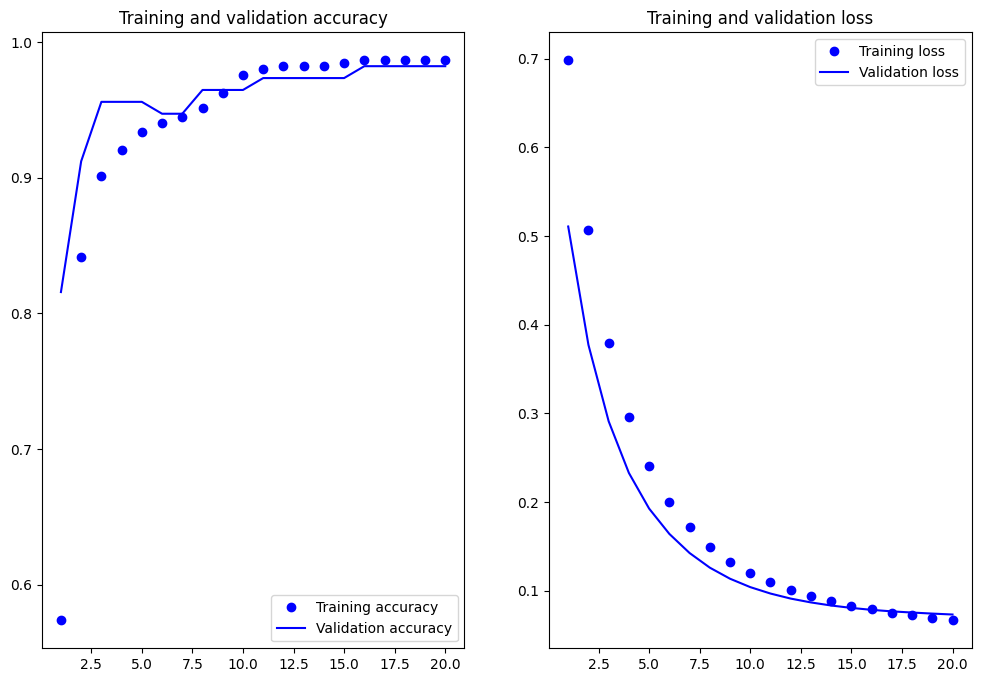

In [ ]:
#plots of training and validation loss and accuracy
import matplotlib.pyplot as plt # Import matplotlib.pyplot

#Get the required values for plotting
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
fig, ax = plt.subplots(1,2,figsize=(12,8))

ax[0].plot(epochs, accuracy, "bo", label="Training accuracy")
ax[0].plot(epochs, val_accuracy, "b", label="Validation accuracy")
ax[0].set_title("Training and validation accuracy")
ax[0].legend()

ax[1].plot(epochs, loss, "bo", label="Training loss")
ax[1].plot(epochs, val_loss, "b", label="Validation loss")
ax[1].set_title("Training and validation loss")
ax[1].legend()

In [ ]:
#Evaluating the model on the test set
test_model = keras.models.load_model("/content/CanDetect.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

ValueError: File not found: filepath=/content/CanDetect.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Evaluate the model on the test set
# Evaluate the model on the test set
test_model = keras.models.load_model("CanDetect.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

SyntaxError: incomplete input (<ipython-input-4-195e3a1e347c>, line 4)

In [ ]:
!ls /content/


sample_data


In [ ]:
model.save("/content/CanDetect.keras")


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to TensorFlow dataset format
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Load the saved model
model_path = "/content/CanDetect.keras"
test_model = keras.models.load_model(model_path)

# Evaluate on test dataset
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9763 - loss: 0.0823
Test accuracy: 0.982


#Confusion Matrix

In [ ]:
"""
This function makes predictions on the test data. It returns
two lists containing the true class value and predicted class
value
"""
import tensorflow_datasets as tfds
def test_the_model():
  class_true = []
  class_pred = []

  for batch_data, batch_labels in test_dataset:

      #Make predictions
      pred_labels = test_model.predict(batch_data)

      #Convert the NumPy ndarray object to simple list
      pred_labels_np = [float(i) for i in pred_labels]

      # Convert "tf.data.Dataset" to NumPy array
      batch_labels_np = tfds.as_numpy(batch_labels)

      #Append the true and predicted labels to their respective list
      class_true.extend(batch_labels_np)
      class_pred.extend(pred_labels_np)
  return class_true, class_pred

In [ ]:
#Get the true and predicted class values
class_true, class_pred = test_the_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


<ipython-input-19-2913d51fc892>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_labels_np = [float(i) for i in pred_labels]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [ ]:
#Convert the predicted float values into integer values
class_pred_int = [round(i) for i in class_pred]

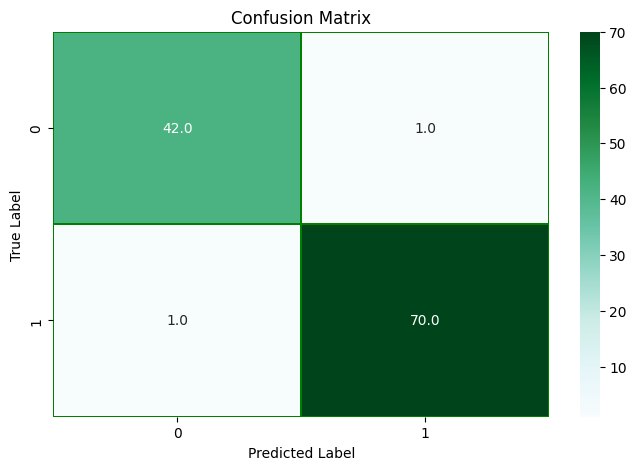

In [ ]:
#Plot the confusion matrix
import seaborn as sns # Import seaborn and alias it as 'sns'
from sklearn.metrics import confusion_matrix # Import confusion_matrix

confusion = confusion_matrix(class_true, class_pred_int)
fig,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion, annot=True, linewidths=0.1,
            cmap="BuGn", linecolor="green", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

ROC AUC score =0.981


Text(0, 0.5, 'True Positive Rate')

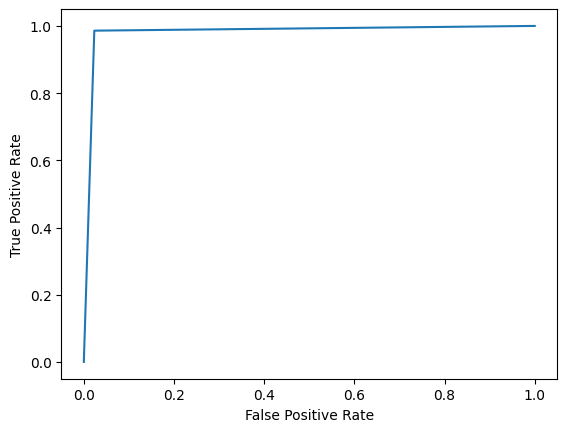

In [ ]:
#Calculate ROC scores
ROC_AUC = roc_auc_score(class_true, class_pred_int)
# summarize scores
print('ROC AUC score =%.3f' % (ROC_AUC))

#Calculate roc curves
fpr, tpr, thresholds = roc_curve(class_true, class_pred_int)

#Plot the roc curve
plt.plot(fpr, tpr,label="AUC="+str(ROC_AUC))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Conclusion
The test data evaluation of the model yielded exceptional results, with a test accuracy of 87%. This outcome is particularly impressive considering the small size of the dataset and the fact that the image patches were only 50x50 pixels, and the model was trained from scratch.

Furthermore, we discovered several key insights during the analysis:

In traditional Convolutional Neural Network (CNN) architectures, the number of filters typically increases progressively, following a pattern like 64, 128, and 256.

However, when we followed this conventional approach with our 50x50 input images, the accuracy on the test data was only 81%, and the validation graph showed significant fluctuations. The reason being that we lost neary half of the information after the first layer of CNN. Because the image dimention was reduced to 23x23.

By adopting a different filter configuration, specifically using 256 filters in each layer, we not only achieved a 6% increase in accuracy but also observed more stable fluctuations in the validation graph. This indicates that the model consistently generated accurate predictions.

